In [48]:
# import the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import datetime as dt

In [2]:
df = pd.read_csv('../datasets/cleaned_orders.csv')
print(df.dtypes)
df.head(3)

customer_id                               int64
order_date                               object
order_time                               object
item_id                                  object
item_quantity                             int64
item_price                              float64
item_discount_raw                       float64
item_discount_percentage                float64
item_disc_bins_item_disc_null             int64
item_disc_bins_item_disc_sub_twenty       int64
item_disc_bins_item_disc_sub_forty        int64
item_disc_bins_item_disc_sub_sixty        int64
item_disc_bins_item_disc_sub_eighty       int64
item_disc_bins_item_disc_sub_hundred      int64
dtype: object


,customer_id,order_date,order_time,item_id,item_quantity,item_price,item_discount_raw,item_discount_percentage,item_disc_bins_item_disc_null,item_disc_bins_item_disc_sub_twenty,item_disc_bins_item_disc_sub_forty,item_disc_bins_item_disc_sub_sixty,item_disc_bins_item_disc_sub_eighty,item_disc_bins_item_disc_sub_hundred
0,0,2022-04-29,18:29:49,Arzuaga blanco,1,49.0,0.0,0.0,1,0,0,0,0,0
1,0,2022-04-29,18:29:49,Arzuaga reserva,1,94.0,0.0,0.0,1,0,0,0,0,0
2,1,2022-04-22,18:08:59,Eclisse,1,51.0,0.0,0.0,1,0,0,0,0,0


## Get a sample of the data

In [163]:
grouped = df[['order_date','item_id','item_quantity']]
groupedbyitem = grouped.groupby('item_id', group_keys=True).apply(lambda x:x)

In [164]:
groupedbyitem['item_id'].value_counts()

Glassware                          728
Wine Virgin                        325
Rara Neagră de Purcari 2020        110
Wine Nut                            86
Puchang Beichun 2015                81
                                  ... 
GT Spain                             1
Blink Wines                          1
Freehand Ormus Field Blend 2020      1
Fumo olive oil                       1
Muga Gift Set                        1
Name: item_id, Length: 4481, dtype: int64

In [175]:
sample = groupedbyitem[groupedbyitem['item_id']=='Rara Neagră de Purcari 2020']
sample = sample.groupby('order_date')['item_quantity'].sum().reset_index()
sample

,order_date,item_quantity
0,2022-04-08,2
1,2022-04-13,3
2,2022-04-15,1
3,2022-04-16,1
4,2022-04-17,1
...,...,...
84,2023-06-27,1
85,2023-07-04,1
86,2023-07-08,1
87,2023-07-12,1


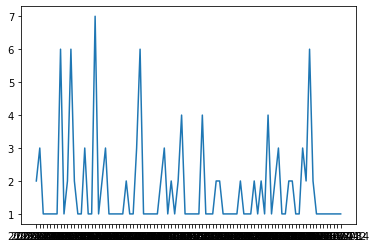

In [176]:
#x = sample['order_time']
#y = sample['item_quantity']
plt.plot(sample['order_date'], sample['item_quantity'])

In [177]:
sample['order_date'] = pd.to_datetime(sample['order_date'])

In [178]:
sample = sample.set_index('order_date').rename_axis(None)

for_model = pd.DataFrame()
for_model['qty'] = sample['item_quantity'].resample('D').mean()
# resamples daily
# next, try .sum()

In [179]:
for_model = for_model.fillna(0)

# Exponential Smoothing
- holt-winters aka 'triple' smoothing
    - expands on simple exponential smoothing by assuming that the time series has a trend (e.g. overall increasing over time)

In [124]:
import itertools
import statsmodels.api as sm   
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error # metric kevan used
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holt-Winters 
from statsmodels.tsa.holtwinters import SimpleExpSmoothing #
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt 

In [185]:
for_model

,qty
2022-04-08,2.0
2022-04-09,0.0
2022-04-10,0.0
2022-04-11,0.0
2022-04-12,0.0
...,...
2023-07-10,0.0
2023-07-11,0.0
2023-07-12,1.0
2023-07-13,0.0


In [181]:
# Dickey-Fuller test for stationarity

def check(data):
    # based on hypothesis testing ish
    # H0 = data is non stationary (there is a trend)
    # H1 = data is stationary
    p_value = sm.tsa.stattools.adfuller(data)[1]
    print('p-value of H0: ' + str(round(p_value,5)))
    
    if p_value < 0.05: # based on jc stats lol
        print('Reject H0. Data is stationary.')
    else:
        print('H0: data is not stationary.')
        
check(for_model)

p-value of H0: 0.0
Reject H0. Data is stationary.


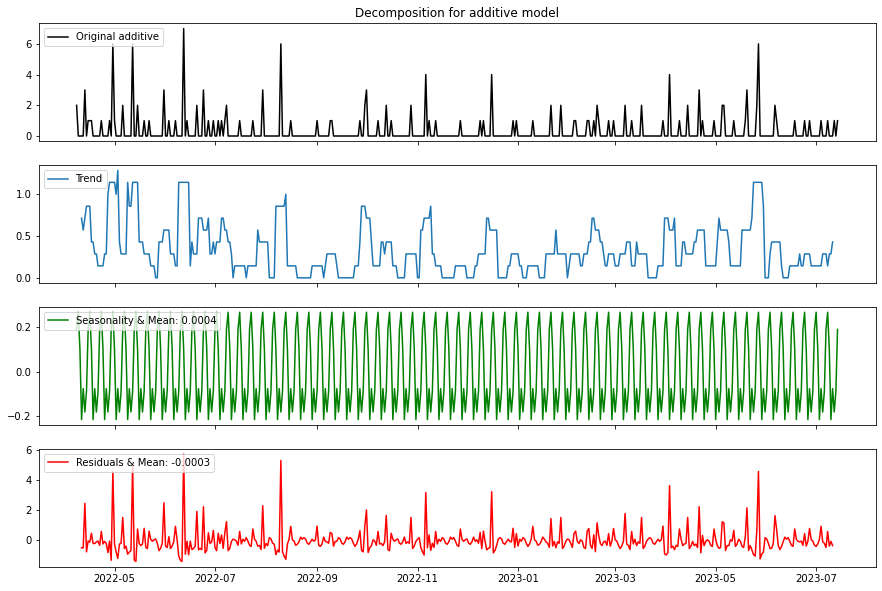

In [186]:
# assuming non-stationarity

def decompose(data, model="additive", stationary=False):
    result = seasonal_decompose(data, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(for_model, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

    if stationary:
        is_stationary(for_model)

decompose(for_model, stationary=False)
# if stationary param = True, check function will be called to test stationarity again

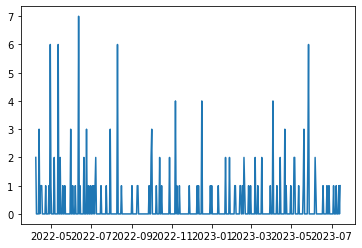

In [187]:
plt.plot(for_model)

In [188]:
import math

size = len(for_model)
train = for_model.iloc[0:math.ceil(size*0.8)]
test = for_model.iloc[math.ceil(size*0.8)::]

In [189]:
ses_results = pd.DataFrame([], columns=['smoothing_level', 'mae', 'mape'])

for x in range(1, 10, 1):
    level = x/10
    ses = SimpleExpSmoothing(train).fit(smoothing_level=level)
    y_pred = ses.forecast(len(test)) # e.g. 3 = 3 months
    temp = [level, round(mean_absolute_error(test, y_pred),5), round(mean_absolute_percentage_error(test, y_pred),5)]
    ses_results.loc[len(ses_results)] = temp

ses_results

,smoothing_level,mae,mape
0,0.1,0.51109,8.825207e+14
1,0.2,0.47008,6.267896e+14
2,0.3,0.43061,3.806684e+14
3,0.4,0.40451,2.179194e+14
4,0.5,0.38835,1.171339e+14
5,0.6,0.37839,5.502984e+13
6,0.7,0.37278,2.004263e+13
7,0.8,0.37029,4.512587e+12
8,0.9,0.36962,3.172113e+11


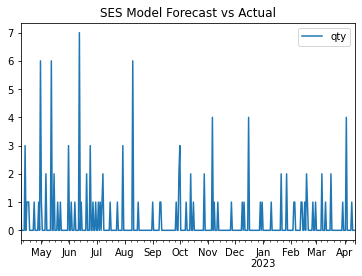

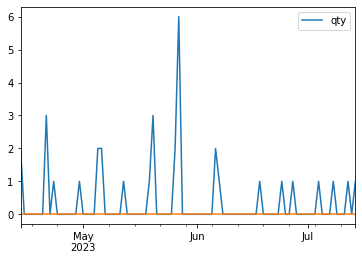

In [190]:
# SES model plotting
train.plot(title='SES Model Forecast vs Actual')
test.plot()
y_pred.plot()
plt.show()

In [194]:
es_results = pd.DataFrame([], columns=['smoothing_seasonal', 'mae', 'mape'])

for x in range(1, 10, 1):
    level = x/10
    ses = ExponentialSmoothing(train,trend='add',seasonal='add',seasonal_periods=12).fit(smoothing_seasonal=level)
    y_pred = es.forecast(len(test))
    temp = [level, round(mean_absolute_error(test, y_pred),3), round(mean_absolute_percentage_error(test, y_pred),3)]
    es_results.loc[len(es_results)] = temp

ses_results

,smoothing_level,mae,mape
0,0.1,0.51109,8.825207e+14
1,0.2,0.47008,6.267896e+14
2,0.3,0.43061,3.806684e+14
3,0.4,0.40451,2.179194e+14
4,0.5,0.38835,1.171339e+14
5,0.6,0.37839,5.502984e+13
6,0.7,0.37278,2.004263e+13
7,0.8,0.37029,4.512587e+12
8,0.9,0.36962,3.172113e+11


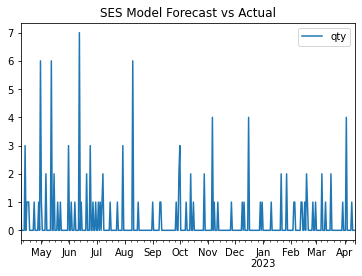

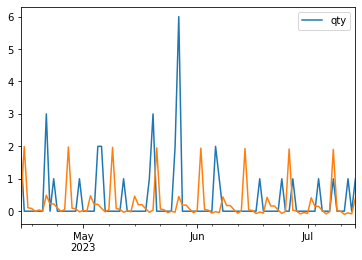

In [195]:
train.plot(title='SES Model Forecast vs Actual')
test.plot()
y_pred2.plot()
plt.show()